# Chapter 11: Deep neural network (DNN)

### 11.1. Intuition behind DNN
> ###### 11.1.1. Forward propagation
> ###### 11.1.2. Gradient descent
> ###### 11.1.3. Backpropagation

### 11.2. DDN for classification
> ###### 11.2.1. Preparation of data
> ###### 11.2.2. Implement a DNN for a classification task
> ###### 11.2.3. Prediction and backtest

### 11.3. DNN for regression
> ###### 11.3.1. Implement a DNN for a regression task
> ###### 11.3.2. Custom loss function
> ###### 11.3.3. Prediction and backtest

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *
from datetime import datetime
np.random.seed(56)

### 11.2.1. Preparation of data 

In [31]:
# Import the data
df = yf.download("AAPL", end=datetime.today().strftime('%Y-%m-%d') )[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)


# NORMALIZATION 
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed


### 11.2.2. Implement a DNN for a classification task

In [34]:
np.random.seed(15)
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 1


# INTIALIZATION SEQUENTIAL MODEL
classifier = Sequential()

# AJOUT COUCHE DENSE ET DROPOUT
for _ in range(nb_hidden_layer):
    classifier.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# AJOUT COUCHE DENSE
classifier.add(Dense(1, activation="sigmoid"))

# COMPILATION DU MODÈLE
classifier.compile(loss="binary_crossentropy", optimizer="adam")

# TRAINING
classifier.fit(X_train_scaled, y_train_cla, epochs=500, batch_size=150, verbose=1)

Epoch 1/500
56/56 [==============================] - 1s 2ms/step - loss: 0.6953
Epoch 2/500
56/56 [==============================] - 0s 3ms/step - loss: 0.6926
Epoch 3/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6920
Epoch 4/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6913
Epoch 5/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6911
Epoch 6/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6911
Epoch 7/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6906
Epoch 8/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6908
Epoch 9/500
56/56 [==============================] - 0s 3ms/step - loss: 0.6907
Epoch 10/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6901
Epoch 11/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6904
Epoch 12/500
56/56 [==============================] - 0s 2ms/step - loss: 0.6898
Epoch 13/500
56/56 [=================

### 10.2.3. Predictions and backtest

326/326 [==============================] - 1s 2ms/step
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.22 	 Alpha: 16.36 %	     Sharpe: 0.586 	 Sortino: 0.825
  -----------------------------------------------------------------------------
    VaR: 84.05 %	 cVaR: 99.63 % 	     VaR/cVaR: 1.185 	 drawdown: 81.8 %
  -----------------------------------------------------------------------------


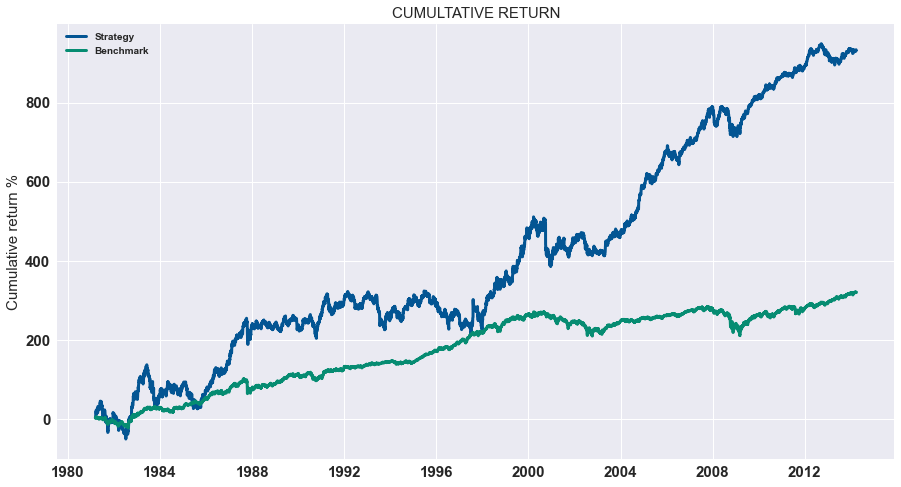

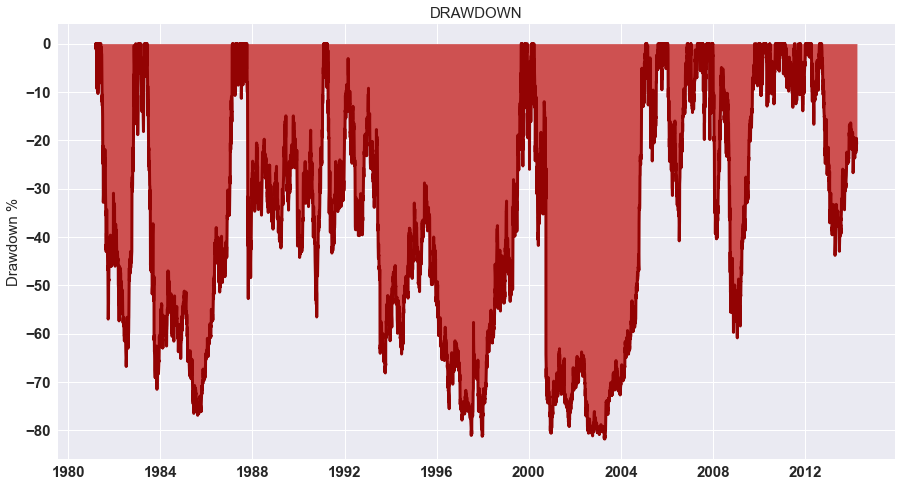

In [35]:
# Create predictions for the whole dataset
df["prediction"] = classifier.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"] == 0, -1,1)
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[:split])


### 10.3.1. Implement a DNN for a regression task¶

In [43]:
np.random.seed(15)# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nb_hidden_layer = 1


# INTIALIZATION SEQUENTIAL MODEL
regressor = Sequential()

# ADD HIDDEN LAYER
for _ in range(nb_hidden_layer):
    regressor.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# OUTPUT LAYER DENSE
regressor.add(Dense(1, activation="linear"))

# COMPILE THE MODEL
regressor.compile(loss="mse", optimizer="adam")

# TRAINING
regressor.fit(X_train_scaled, y_train_reg, epochs=500, batch_size=32, verbose=1)

Epoch 1/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 2/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 3/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 4/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 7/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 8/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 9/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 10/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 11/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 12/500
261/261 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 13/500


326/326 [==============================] - 0s 1ms/step
Date
1981-03-12    0.001670
1981-03-13    0.001376
1981-03-16    0.001529
1981-03-17    0.001376
1981-03-18    0.001376
                ...   
2022-07-01    0.001614
2022-07-05    0.001442
2022-07-06    0.001422
2022-07-07    0.001460
2022-07-08    0.001389
Name: prediction, Length: 10420, dtype: float32
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.191 	 Alpha: 17.61 %	     Sharpe: 1.048 	 Sortino: 1.422
  -----------------------------------------------------------------------------
    VaR: 37.1 %	 cVaR: 46.44 % 	     VaR/cVaR: 1.252 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


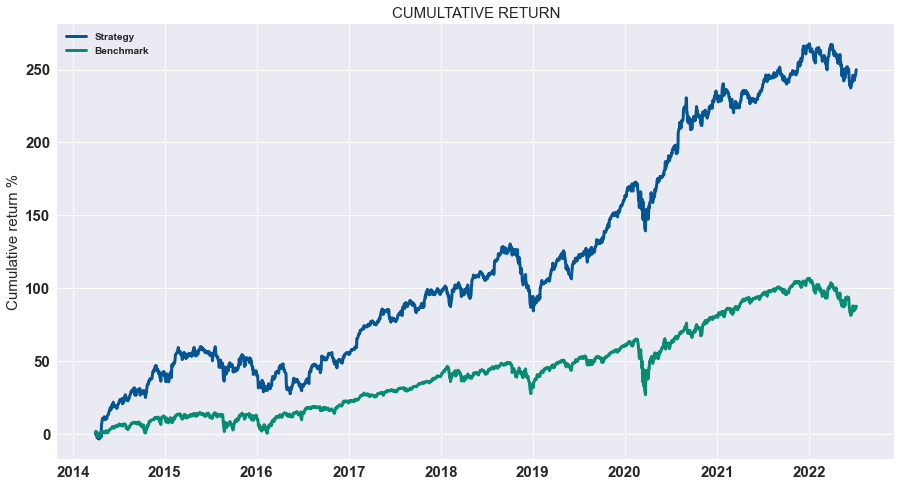

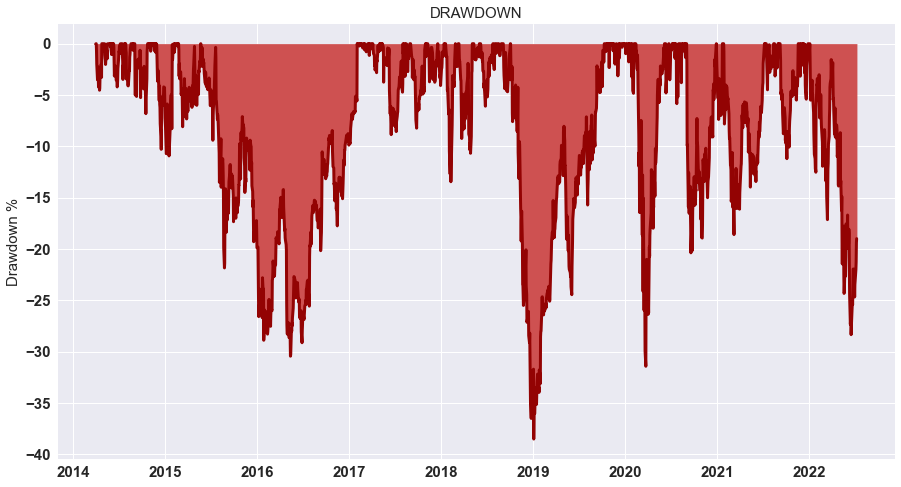

In [45]:
# Create predictions for the whole dataset
df["prediction"] = regressor.predict(np.concatenate((X_train,X_test),
                                    axis=0))
print(df["prediction"])

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

In [46]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as F

def ALPHA_MSE(y_true, y_pred):
    y_true_roll = tf.roll(y_true, shift=1, axis=0)
    y_pred_roll = tf.roll(y_pred, shift=1, axis=0)
    y_true_dif = tf.math.sign(y_true_roll-y_true)
    y_pred_dif = tf.math.sign(y_pred_roll-y_pred)
    booleen_vector = y_true_dif == y_pred_dif
    alpha = tf.where(booleen_vector, 1, 3)
    alpha = tf.cast(alpha, dtype=tf.float32)
    mse = F.square(y_true-y_pred)
    mse = tf.cast(mse, dtype=tf.float32)
    scale_mse = tf.multiply(alpha, mse)
    alpha_mse = F.mean(scale_mse)
    return alpha_mse

Epoch 1/13
261/261 [==============================] - 1s 2ms/step - loss: 0.0045
Epoch 2/13
261/261 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 3/13
261/261 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 4/13
261/261 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 5/13
261/261 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 6/13
261/261 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 7/13
261/261 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 8/13
261/261 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 9/13
261/261 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 10/13
261/261 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 11/13
261/261 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 12/13
261/261 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 13/13
326/326 [====

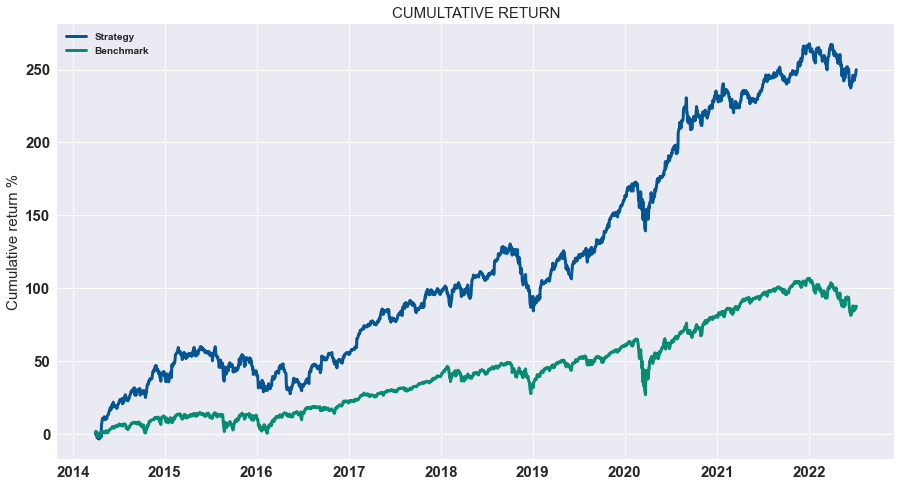

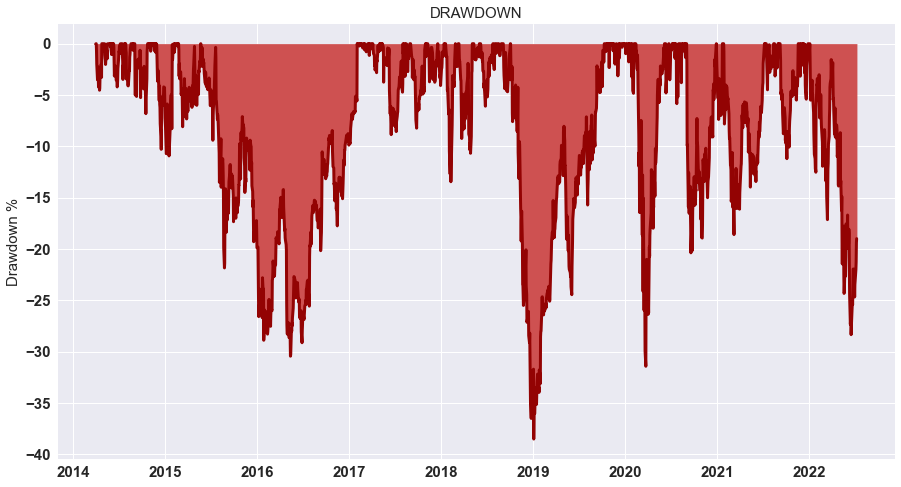

In [47]:
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 3

np.random.seed(15)
# INTIALIZATION SEQUENTIAL MODEL
regressor = Sequential()

# AJOUT COUCHE DENSE ET DROPOUT
for _ in range(nb_hidden_layer):
    regressor.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# AJOUT COUCHE DENSE
regressor.add(Dense(1, activation="linear"))

# COMPILATION DU MODÈLE
regressor.compile(loss=ALPHA_MSE, optimizer="adam")

regressor.fit(X_train_scaled, y_train_reg, epochs=13, batch_size=32, verbose=1)

# Create predictions for the whole dataset
df["prediction"] = regressor.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
from Backtest import *
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

# Applied Deep neural network (DNN)

### 11.1. Live Trading using DNN
> ###### 11.1.1. Connect to MetaTrader5 Platform
> ###### 11.1.2. Create a DNN for a classification task
> ###### 11.1.3. Execute Model



In [69]:
 # LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time
import pickle
from joblib import dump, load
import os
from sklearn.preprocessing import StandardScaler



In [70]:
path = "C:/Users/samma/PycharmProjects/AlphaQuant-Labs/Research_Models/Machine Learning Models/Chapter_11/Models"
# Ex: C:/Desktop/Python_for_finance_and_algorithmic_trading/ChapterN/Models

In [80]:
def ANN():
    # Create the model
    nb_hidden_layer = 1


    # INTIALIZATION SEQUENTIAL MODEL
    alg = Sequential()

    # ADD HIDDEN LAYER
    for _ in range(nb_hidden_layer):
        alg.add(Dense(75, input_shape = (5,), activation="relu"))


    # OUTPUT LAYER DENSE
    alg.add(Dense(1, activation="linear"))

    # COMPILE THE MODEL
    alg.compile(loss="mse", optimizer="adam")
    return alg

def create_model_weights(symbol):
    """ Weights for Linear regression on the percentage change"""
    # Import the data
    data = MT5.get_data(symbol, 3500)[["close"]].pct_change(1)

    # Create new variable
    data.columns = ["returns"]

    # Features engeeniring
    data["returns t-1"] = data[["returns"]].shift(1)

    # Mean of returns
    data["mean returns 15"] = data[["returns"]].rolling(15).mean().shift(1)
    data["mean returns 60"] = data[["returns"]].rolling(60).mean().shift(1)

    # Volatility of returns
    data["volatility returns 15"] = data[["returns"]].rolling(15).std().shift(1)
    data["volatility returns 60"] = data[["returns"]].rolling(60).std().shift(1)

    # Split the data
    data = data.dropna()
    split = int(0.80*len(data))

    # Train set creation
    X_train = data[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]
    y_train = data[["returns"]].iloc[:split]

    # Initialize the class
    sc = StandardScaler()

    # Standardize the data
    X_train = sc.fit_transform(X_train)

    alg = ANN()

    # TRAINING
    alg.fit(X_train, y_train, epochs=13, batch_size=32, verbose=1)

    # Save the model
    alg.save_weights(os.path.join(path,f"Models/ANN_reg_{symbol}"))



def ANN_cla_sig(symbol):
    """ Function for predict the value of tommorow using ARIMA model"""

    # Create the weights if there is not in the folder
    try:
        alg = ANN()
        alg.load_weights(os.path.join(path,f"Models/ANN_reg_{symbol}"))
    except:
        create_model_weights(symbol)
        alg = ANN()
        alg.load_weights(os.path.join(path,f"Models/ANN_reg_{symbol}"))

    # Take the lastest percentage of change
    data = MT5.get_data(symbol, 3500)[["close"]].pct_change(1)
    # Create new variable
    data.columns = ["returns"]

    # Features engeeniring

    # Mean of returns
    data["mean returns 15"] = data[["returns"]].rolling(15).mean()
    data["mean returns 60"] = data[["returns"]].rolling(60).mean()

    # Volatility of returns
    data["volatility returns 15"] = data[["returns"]].rolling(15).std()
    data["volatility returns 60"] = data[["returns"]].rolling(60).std()

    X = data[["returns", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[-1:,:].values

    # Find the signal
    prediction = alg.predict(X)
    prediction = np.where(prediction==0, -1, 1)
    buy = prediction[0][0] > 0
    sell = not buy


    return buy, sell



# True = Live Trading and False = Screener
live = True
from MT5 import *

if live:
    current_account_info = mt5.account_info()
    print("------------------------------------------------------------------")
    print("Date: ", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(f"Balance: {current_account_info.balance} USD, \t"
          f"Equity: {current_account_info.equity} USD, \t"
          f"Profit: {current_account_info.profit} USD")
    print("------------------------------------------------------------------")



info_order = {
    "Apple": ["BTCUSD", 1.00]
}


start = datetime.now().strftime("%H:%M:%S")
while True:
    # Verfication for launch
    if datetime.now().weekday() not in (5,1):
        is_time = datetime.now().strftime("%H:%M:%S") == start #"23:59:59"
    else:
        is_time = False


    # Launch the algorithm
    if is_time:

        # Open the trades
        for asset in info_order.keys():

            # Initialize the inputs
            symbol = info_order[asset][0]
            lot = info_order[asset][1]

            # Create the signals
            buy, sell = ANN_cla_sig(symbol)

             # Run the algorithm
            if live:
                MT5.run(symbol, buy, sell,lot)

            else:
                print(f"Symbol: {symbol}\t"
                     f"Buy: {buy}\t"
                     f"Sell: {sell}")
    time.sleep(1)

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core.multiarray failed to import